In [1]:
import numpy as np
import pandas as pd
import torch
import random
import torch.nn as nn
import re
import tensorflow as tf

In [2]:
import math
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, RNN, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [7]:
seed_val = 1
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [8]:
df = pd.read_csv("https://raw.githubusercontent.com/ammaarahmad1999/Time_Series_Dataset/main/bbc.csv", index_col=0)

In [9]:
label_dict = {'business': 0, 'entertainment' : 1, 'politics' : 2, 'sport' : 3, 'tech' : 4}

In [10]:
df['labels'] = df['Class'].replace(label_dict)

In [11]:
vocabulary = set()

In [12]:
accuracy_models = dict()

#Data Preprocessing

In [13]:
def cleaning(text):
  line = re.sub('[^A-Za-z0-9]+', ' ', text)
  tokens = line.split()
  tokens = [w for w in tokens if not w.lower() in STOPWORDS]
  text = " ".join(tokens)
  for word in tokens:
    vocabulary.add(word)
  return text
def length(text):
  return len(text.split())
df['text'] = df['Article'].apply(cleaning)
df['length'] = df['text'].apply(length)

In [14]:
df = df.sample(frac = 1, random_state = 1)

In [15]:
df.reset_index(drop = True, inplace = True)

In [16]:
df

,Article,Class,labels,text,length
0,Cactus diet deal for Phytopharm\n\nA slimming ...,business,0,Cactus diet deal Phytopharm slimming aid made ...,143
1,Winter freeze keeps oil above $50\n\nOil price...,business,0,Winter freeze keeps oil 50 Oil prices carried ...,201
2,Mobiles rack up 20 years of use\n\nMobile phon...,tech,4,Mobiles rack 20 years use Mobile phones UK cel...,255
3,Giving financial gifts to children\n\nYour chi...,business,0,Giving financial gifts children child grandchi...,436
4,Bank payout to Pinochet victims\n\nA US bank h...,business,0,Bank payout Pinochet victims US bank said dona...,184
...,...,...,...,...,...
1907,Crucial decision on super-casinos\n\nA decisio...,politics,2,Crucial decision super casinos decision whethe...,108
1908,Cyber crime booms in 2004\n\nThe last 12 month...,tech,4,Cyber crime booms 2004 last 12 months seen dra...,471
1909,Howard rejects BNP's claim\n\nTory leader Mich...,politics,2,Howard rejects BNP claim Tory leader Michael H...,184
1910,Card fraudsters 'targeting web'\n\nNew safegua...,business,0,Card fraudsters targeting web New safeguards c...,248


In [17]:
df['Class'].value_counts()

business         510
politics         417
tech             401
entertainment    386
sport            198
Name: Class, dtype: int64

In [18]:
df['length'].max()

2225

In [19]:
df['length'].mean()

232.6600418410042

In [21]:
len(df[df['length'] > 510])

37

In [22]:
len(df[df['length'] > 510])/len(df)

0.019351464435146442

#Conclusion: On Analysis we found that Maximum Length of Sentence = 2225 
# Average Length of Sentence = 232.66 and Number of sentences exceeding 
# (length = 510) is just 37. It less than 2% of total number of sentences

In [23]:
vocab_size = len(vocabulary)
embedding_dim = 100     #As mentioned in the Assignment
max_length = 512        # Set to 512
trunc_type = 'post'     # Truncating sentences length > 512
padding_type = 'post'   # Padding Sentences to 512 tokens
oov_tok = '<OOV>'       # Unknown token

In [24]:
train_size = math.ceil(0.7 * len(df))
valid_size = math.ceil(0.8 * len(df))

In [25]:
df_test = df[valid_size:]
df_test.to_csv("Test_Data.csv", index = None)

In [26]:
X_train = df['text'][0:train_size]
X_valid = df['text'][train_size:valid_size]
X_test  = df['text'][valid_size:]
Y_train = pd.get_dummies(df['labels'][0:train_size]).values
Y_valid = pd.get_dummies(df['labels'][train_size:valid_size]).values
Y_test  = pd.get_dummies(df['labels'][valid_size:]).values

In [27]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [28]:
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

In [29]:
X_train = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_valid = pad_sequences(X_valid, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [30]:
X_train.shape

(1339, 512)

#**Q1**

In [31]:
model_statistics = []
num_epochs = 5

#First Model

In [32]:
model_ffnn = Sequential()
model_ffnn.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_ffnn.add(Flatten())
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(512, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(128, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(5, activation='softmax'))

In [33]:
model_ffnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ffnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 100)          3129000   
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [34]:
history = model_ffnn.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
168/168 [==============================] - 38s 222ms/step - loss: 1.2476 - accuracy: 0.4922 - val_loss: 0.3212 - val_accuracy: 0.8901
Epoch 2/5
168/168 [==============================] - 37s 219ms/step - loss: 0.0398 - accuracy: 0.9866 - val_loss: 0.2519 - val_accuracy: 0.9267
Epoch 3/5
168/168 [==============================] - 37s 218ms/step - loss: 7.3579e-04 - accuracy: 1.0000 - val_loss: 0.2174 - val_accuracy: 0.9372
Epoch 4/5
168/168 [==============================] - 37s 219ms/step - loss: 4.5802e-04 - accuracy: 1.0000 - val_loss: 0.2168 - val_accuracy: 0.9372
Epoch 5/5
168/168 [==============================] - 37s 218ms/step - loss: 3.2869e-04 - accuracy: 1.0000 - val_loss: 0.2167 - val_accuracy: 0.9372


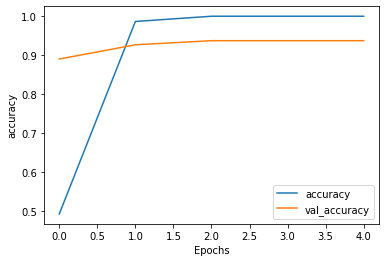

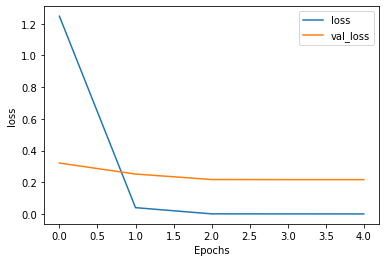

In [36]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [37]:
test_loss, test_accuracy = model_ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_accuracy))

12/12 [==============================] - 1s 46ms/step - loss: 0.1064 - accuracy: 0.9712
Test set
  Loss: 0.106
  Accuracy: 0.971


In [39]:
history.history['accuracy']

[0.49215832352638245, 0.986557126045227, 1.0, 1.0, 1.0]

In [42]:
train_loss = history.history['loss'][4]
valid_loss = history.history['val_loss'][4]
valid_accuracy = history.history['val_accuracy'][4]
model_parameters = model_ffnn.count_params()

In [43]:
model_statistics.append(
        {
            'Model Parameters': model_parameters,
            'Training Loss': train_loss,
            'Validation Loss': valid_loss,
            'Validation Accuracy': valid_accuracy,
            'Test Accuracy': test_accuracy,
        }
    )

In [45]:
prediction_ffnn = model_ffnn.predict(X_test)
prediction_ffnn = np.argmax(prediction_ffnn, axis = 1)

In [46]:
accuracy = accuracy_score(df_test['labels'], prediction_ffnn)
accuracy_models[model_parameters] = accuracy
print(f'Accuracy of Model = {accuracy}')
print(classification_report(df_test['labels'], prediction_ffnn))

Accuracy of Model = 0.9712041884816754
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        93
           1       0.95      0.99      0.97        76
           2       0.95      0.98      0.96        82
           3       1.00      0.95      0.98        42
           4       0.99      0.99      0.99        89

    accuracy                           0.97       382
   macro avg       0.97      0.97      0.97       382
weighted avg       0.97      0.97      0.97       382



In [47]:
df_stats = pd.DataFrame(data = model_statistics)
df_stats.to_csv("Statistics.csv", index = None)

#Second Model

In [48]:
model_ffnn = Sequential()
model_ffnn.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_ffnn.add(Flatten())
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(1024, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(256, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(5, activation='softmax'))

In [49]:
model_ffnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ffnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 100)          3129000   
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_3 (Dropout)         (None, 51200)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              52429824  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [50]:
history = model_ffnn.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
168/168 [==============================] - 73s 431ms/step - loss: 1.4419 - accuracy: 0.4369 - val_loss: 0.4499 - val_accuracy: 0.8482
Epoch 2/5
168/168 [==============================] - 72s 431ms/step - loss: 0.0535 - accuracy: 0.9828 - val_loss: 0.2693 - val_accuracy: 0.9215
Epoch 3/5
168/168 [==============================] - 72s 430ms/step - loss: 5.8604e-04 - accuracy: 1.0000 - val_loss: 0.2514 - val_accuracy: 0.9215
Epoch 4/5
168/168 [==============================] - 72s 430ms/step - loss: 1.8159e-04 - accuracy: 1.0000 - val_loss: 0.2559 - val_accuracy: 0.9162
Epoch 5/5
168/168 [==============================] - 72s 431ms/step - loss: 1.0314e-04 - accuracy: 1.0000 - val_loss: 0.2568 - val_accuracy: 0.9162


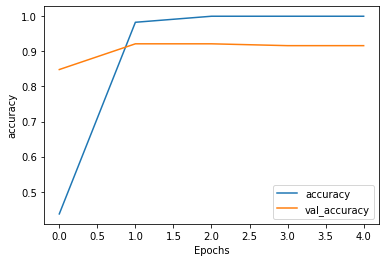

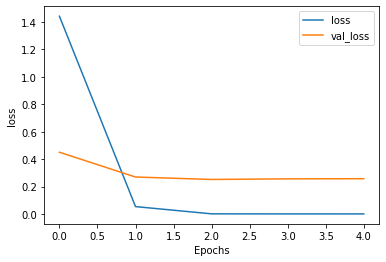

In [51]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [52]:
test_loss, test_accuracy = model_ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_accuracy))

12/12 [==============================] - 1s 89ms/step - loss: 0.2031 - accuracy: 0.9215
Test set
  Loss: 0.203
  Accuracy: 0.921


In [53]:
history.history['accuracy']

[0.43689319491386414, 0.9828230142593384, 1.0, 1.0, 1.0]

In [54]:
train_loss = history.history['loss'][4]
valid_loss = history.history['val_loss'][4]
valid_accuracy = history.history['val_accuracy'][4]
model_parameters = model_ffnn.count_params()

In [55]:
model_statistics.append(
        {
            'Model Parameters': model_parameters,
            'Training Loss': train_loss,
            'Validation Loss': valid_loss,
            'Validation Accuracy': valid_accuracy,
            'Test Accuracy': test_accuracy,
        }
    )

In [56]:
prediction_ffnn = model_ffnn.predict(X_test)
prediction_ffnn = np.argmax(prediction_ffnn, axis = 1)

In [57]:
accuracy = accuracy_score(df_test['labels'], prediction_ffnn)
accuracy_models[model_parameters] = accuracy
print(f'Accuracy of Model = {accuracy}')
print(classification_report(df_test['labels'], prediction_ffnn))

Accuracy of Model = 0.9214659685863874
              precision    recall  f1-score   support

           0       0.91      0.92      0.92        93
           1       0.89      0.92      0.90        76
           2       0.90      0.91      0.91        82
           3       0.95      0.93      0.94        42
           4       0.96      0.92      0.94        89

    accuracy                           0.92       382
   macro avg       0.92      0.92      0.92       382
weighted avg       0.92      0.92      0.92       382



In [58]:
df_stats = pd.DataFrame(data = model_statistics)
df_stats.to_csv("Statistics.csv", index = None)

#Third Model

In [59]:
model_ffnn = Sequential()
model_ffnn.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_ffnn.add(Flatten())
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(1024, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(256, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(64, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(5, activation='softmax'))

In [60]:
model_ffnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ffnn.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 100)          3129000   
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_6 (Dropout)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              52429824  
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               262400    
                                                                 
 dropout_8 (Dropout)         (None, 256)              

In [61]:
history = model_ffnn.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
168/168 [==============================] - 74s 437ms/step - loss: 1.6051 - accuracy: 0.3361 - val_loss: 0.7935 - val_accuracy: 0.6963
Epoch 2/5
168/168 [==============================] - 73s 434ms/step - loss: 0.2602 - accuracy: 0.9029 - val_loss: 0.2933 - val_accuracy: 0.9058
Epoch 3/5
168/168 [==============================] - 72s 431ms/step - loss: 0.0149 - accuracy: 0.9978 - val_loss: 0.2589 - val_accuracy: 0.9162
Epoch 4/5
168/168 [==============================] - 72s 431ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2301 - val_accuracy: 0.9319
Epoch 5/5
168/168 [==============================] - 72s 431ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.2312 - val_accuracy: 0.9319


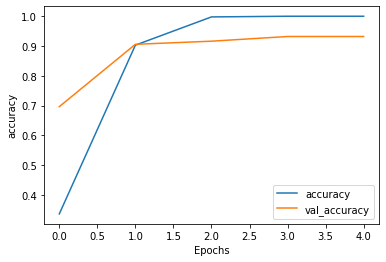

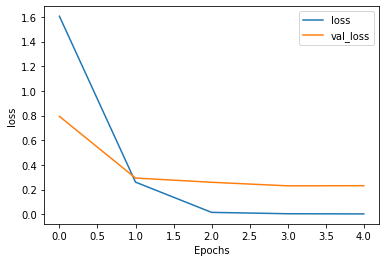

In [62]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [63]:
test_loss, test_accuracy = model_ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_accuracy))

12/12 [==============================] - 1s 89ms/step - loss: 0.2369 - accuracy: 0.9319
Test set
  Loss: 0.237
  Accuracy: 0.932


In [64]:
history.history['accuracy']

[0.3360716998577118, 0.9029126167297363, 0.9977595210075378, 1.0, 1.0]

In [65]:
train_loss = history.history['loss'][4]
valid_loss = history.history['val_loss'][4]
valid_accuracy = history.history['val_accuracy'][4]
model_parameters = model_ffnn.count_params()

In [66]:
model_statistics.append(
        {
            'Model Parameters': model_parameters,
            'Training Loss': train_loss,
            'Validation Loss': valid_loss,
            'Validation Accuracy': valid_accuracy,
            'Test Accuracy': test_accuracy,
        }
    )

In [67]:
prediction_ffnn = model_ffnn.predict(X_test)
prediction_ffnn = np.argmax(prediction_ffnn, axis = 1)

In [68]:
accuracy = accuracy_score(df_test['labels'], prediction_ffnn)
accuracy_models[model_parameters] = accuracy
print(f'Accuracy of Model = {accuracy}')
print(classification_report(df_test['labels'], prediction_ffnn))

Accuracy of Model = 0.9319371727748691
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        93
           1       0.96      0.92      0.94        76
           2       0.95      0.90      0.92        82
           3       0.84      1.00      0.91        42
           4       0.99      0.89      0.93        89

    accuracy                           0.93       382
   macro avg       0.93      0.94      0.93       382
weighted avg       0.94      0.93      0.93       382



In [69]:
df_stats = pd.DataFrame(data = model_statistics)
df_stats.to_csv("Statistics.csv", index = None)

#Fourth Model

In [70]:
model_ffnn = Sequential()
model_ffnn.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_ffnn.add(Flatten())
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(512, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(5, activation='softmax'))

In [71]:
model_ffnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ffnn.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 512, 100)          3129000   
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_10 (Dropout)        (None, 51200)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 29,346,477
Trainable params: 29,346,477


In [72]:
history = model_ffnn.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
168/168 [==============================] - 39s 226ms/step - loss: 0.9958 - accuracy: 0.6789 - val_loss: 0.1747 - val_accuracy: 0.9476
Epoch 2/5
168/168 [==============================] - 37s 222ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.1563 - val_accuracy: 0.9634
Epoch 3/5
168/168 [==============================] - 37s 223ms/step - loss: 2.7876e-04 - accuracy: 1.0000 - val_loss: 0.1541 - val_accuracy: 0.9581
Epoch 4/5
168/168 [==============================] - 37s 223ms/step - loss: 2.3483e-04 - accuracy: 1.0000 - val_loss: 0.1522 - val_accuracy: 0.9634
Epoch 5/5
168/168 [==============================] - 38s 223ms/step - loss: 1.6570e-04 - accuracy: 1.0000 - val_loss: 0.1511 - val_accuracy: 0.9634


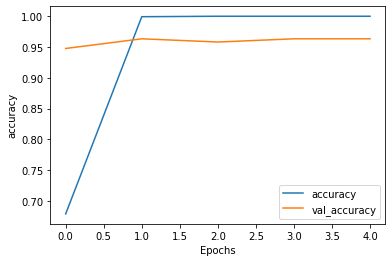

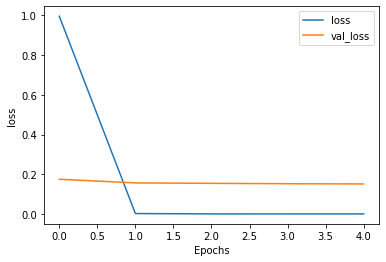

In [73]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [74]:
test_loss, test_accuracy = model_ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_accuracy))

12/12 [==============================] - 1s 45ms/step - loss: 0.1352 - accuracy: 0.9712
Test set
  Loss: 0.135
  Accuracy: 0.971


In [75]:
history.history['accuracy']

[0.6788648366928101, 0.9992531538009644, 1.0, 1.0, 1.0]

In [76]:
train_loss = history.history['loss'][4]
valid_loss = history.history['val_loss'][4]
valid_accuracy = history.history['val_accuracy'][4]
model_parameters = model_ffnn.count_params()

In [77]:
model_statistics.append(
        {
            'Model Parameters': model_parameters,
            'Training Loss': train_loss,
            'Validation Loss': valid_loss,
            'Validation Accuracy': valid_accuracy,
            'Test Accuracy': test_accuracy,
        }
    )

In [78]:
prediction_ffnn = model_ffnn.predict(X_test)
prediction_ffnn = np.argmax(prediction_ffnn, axis = 1)

In [79]:
accuracy = accuracy_score(df_test['labels'], prediction_ffnn)
accuracy_models[model_parameters] = accuracy
print(f'Accuracy of Model = {accuracy}')
print(classification_report(df_test['labels'], prediction_ffnn))

Accuracy of Model = 0.9712041884816754
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        93
           1       0.96      0.95      0.95        76
           2       0.99      0.96      0.98        82
           3       1.00      1.00      1.00        42
           4       0.97      0.97      0.97        89

    accuracy                           0.97       382
   macro avg       0.97      0.97      0.97       382
weighted avg       0.97      0.97      0.97       382



In [80]:
df_stats = pd.DataFrame(data = model_statistics)
df_stats.to_csv("Statistics.csv", index = None)

#Fifth Model

In [83]:
model_ffnn = Sequential()
model_ffnn.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_ffnn.add(Flatten())
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(2048, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(64, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(5, activation='softmax'))

In [84]:
model_ffnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ffnn.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 512, 100)          3129000   
                                                                 
 flatten_5 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_15 (Dropout)        (None, 51200)             0         
                                                                 
 dense_15 (Dense)            (None, 2048)              104859648 
                                                                 
 dropout_16 (Dropout)        (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 64)                131136    
                                                                 
 dropout_17 (Dropout)        (None, 64)               

In [85]:
history = model_ffnn.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
168/168 [==============================] - 140s 828ms/step - loss: 1.7165 - accuracy: 0.2793 - val_loss: 1.4605 - val_accuracy: 0.3717
Epoch 2/5
168/168 [==============================] - 139s 827ms/step - loss: 1.4816 - accuracy: 0.3824 - val_loss: 0.8809 - val_accuracy: 0.6283
Epoch 3/5
168/168 [==============================] - 139s 830ms/step - loss: 0.3889 - accuracy: 0.8581 - val_loss: 0.3330 - val_accuracy: 0.9058
Epoch 4/5
168/168 [==============================] - 139s 828ms/step - loss: 0.0283 - accuracy: 0.9940 - val_loss: 0.2381 - val_accuracy: 0.9476
Epoch 5/5
168/168 [==============================] - 139s 828ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.2195 - val_accuracy: 0.9372


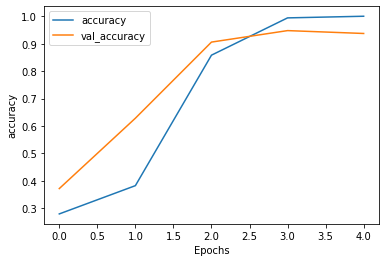

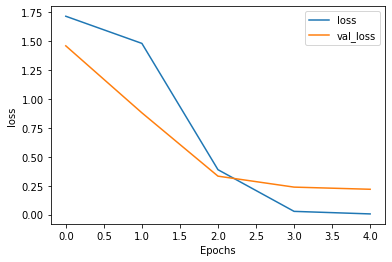

In [86]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [87]:
test_loss, test_accuracy = model_ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_accuracy))

12/12 [==============================] - 2s 181ms/step - loss: 0.1895 - accuracy: 0.9476
Test set
  Loss: 0.190
  Accuracy: 0.948


In [88]:
history.history['accuracy']

[0.2793129086494446,
 0.38237491250038147,
 0.8581030368804932,
 0.9940254092216492,
 1.0]

In [89]:
train_loss = history.history['loss'][4]
valid_loss = history.history['val_loss'][4]
valid_accuracy = history.history['val_accuracy'][4]
model_parameters = model_ffnn.count_params()

In [90]:
model_statistics.append(
        {
            'Model Parameters': model_parameters,
            'Training Loss': train_loss,
            'Validation Loss': valid_loss,
            'Validation Accuracy': valid_accuracy,
            'Test Accuracy': test_accuracy,
        }
    )

In [91]:
prediction_ffnn = model_ffnn.predict(X_test)
prediction_ffnn = np.argmax(prediction_ffnn, axis = 1)

In [92]:
accuracy = accuracy_score(df_test['labels'], prediction_ffnn)
accuracy_models[model_parameters] = accuracy
print(f'Accuracy of Model = {accuracy}')
print(classification_report(df_test['labels'], prediction_ffnn))

Accuracy of Model = 0.9476439790575916
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        93
           1       0.96      0.99      0.97        76
           2       0.96      0.95      0.96        82
           3       0.97      0.90      0.94        42
           4       0.96      0.90      0.93        89

    accuracy                           0.95       382
   macro avg       0.95      0.94      0.95       382
weighted avg       0.95      0.95      0.95       382



In [93]:
df_stats = pd.DataFrame(data = model_statistics)
df_stats.to_csv("Statistics.csv", index = None)

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [97]:
df_stats.sort_values(['Model Parameters', 'Test Accuracy'], inplace = True)

In [98]:
df_stats

,Model Parameters,Training Loss,Validation Loss,Validation Accuracy,Test Accuracy
3,29346477,0.000166,0.151131,0.963351,0.971204
0,29410221,0.000329,0.216730,0.937173,0.971204
1,55822509,0.000103,0.256800,0.916230,0.921466
2,55837997,0.002420,0.231197,0.931937,0.931937
4,108120109,0.006270,0.219498,0.937173,0.947644


Text(0, 0.5, 'Test Accuracy')

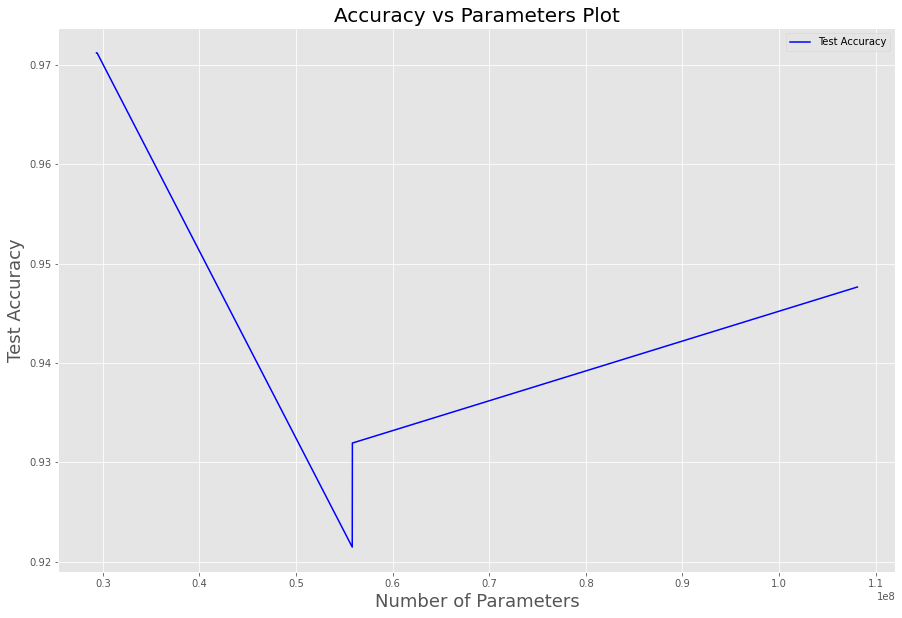

In [99]:
axl = df_stats.plot(kind='line', x='Model Parameters', y='Test Accuracy', color='blue', figsize=(15, 10))
plt.title('Accuracy vs Parameters Plot', size=20)
plt.xlabel('Number of Parameters', size=18)
plt.ylabel('Test Accuracy', size=18)

In [100]:
df_stats.to_csv("Q1_Statistics.csv")

#**Q2**

In [101]:
model_statistics = []

#Tanh Activation and Adam Optimizer

In [114]:
model_ffnn = Sequential()
model_ffnn.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_ffnn.add(Flatten())
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(512, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(128, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(5, activation='softmax'))

In [103]:
model_ffnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ffnn.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 512, 100)          3129000   
                                                                 
 flatten_6 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_18 (Dropout)        (None, 51200)             0         
                                                                 
 dense_18 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               65664     
                                                                 
 dropout_20 (Dropout)        (None, 128)              

In [104]:
history = model_ffnn.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
168/168 [==============================] - 40s 231ms/step - loss: 1.2690 - accuracy: 0.5034 - val_loss: 0.4166 - val_accuracy: 0.8639
Epoch 2/5
168/168 [==============================] - 39s 230ms/step - loss: 0.0333 - accuracy: 0.9940 - val_loss: 0.1952 - val_accuracy: 0.9215
Epoch 3/5
168/168 [==============================] - 38s 229ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1897 - val_accuracy: 0.9319
Epoch 4/5
168/168 [==============================] - 39s 230ms/step - loss: 3.1202e-04 - accuracy: 1.0000 - val_loss: 0.1881 - val_accuracy: 0.9267
Epoch 5/5
168/168 [==============================] - 39s 229ms/step - loss: 2.3208e-04 - accuracy: 1.0000 - val_loss: 0.1880 - val_accuracy: 0.9267


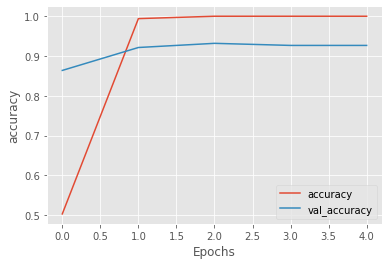

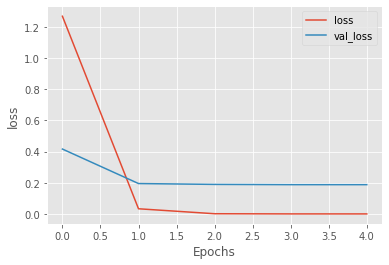

In [105]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [106]:
test_loss, test_accuracy = model_ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_accuracy))

12/12 [==============================] - 1s 49ms/step - loss: 0.1417 - accuracy: 0.9555
Test set
  Loss: 0.142
  Accuracy: 0.955


In [107]:
history.history['accuracy']

[0.5033606886863708, 0.9940254092216492, 1.0, 1.0, 1.0]

In [108]:
train_loss = history.history['loss'][4]
valid_loss = history.history['val_loss'][4]
valid_accuracy = history.history['val_accuracy'][4]

In [110]:
model_statistics.append(
        {
            'Activation Function': 'tanh',
            'Optimizer': 'adam',
            'Training Loss': train_loss,
            'Validation Loss': valid_loss,
            'Validation Accuracy': valid_accuracy,
            'Test Accuracy': test_accuracy,
        }
    )

In [111]:
prediction_ffnn = model_ffnn.predict(X_test)
prediction_ffnn = np.argmax(prediction_ffnn, axis = 1)

In [112]:
accuracy = accuracy_score(df_test['labels'], prediction_ffnn)
accuracy_models[model_parameters] = accuracy
print(f'Accuracy of Model = {accuracy}')
print(classification_report(df_test['labels'], prediction_ffnn))

Accuracy of Model = 0.9554973821989529
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        93
           1       0.95      0.96      0.95        76
           2       0.99      0.98      0.98        82
           3       0.95      0.93      0.94        42
           4       0.98      0.93      0.95        89

    accuracy                           0.96       382
   macro avg       0.96      0.95      0.95       382
weighted avg       0.96      0.96      0.96       382



In [113]:
df_stats = pd.DataFrame(data = model_statistics)
df_stats.to_csv("Statistics.csv", index = None)

#Tanh Activation and SGD Optimizer

In [115]:
model_ffnn = Sequential()
model_ffnn.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_ffnn.add(Flatten())
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(512, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(128, activation='tanh'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(5, activation='softmax'))

In [116]:
model_ffnn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(model_ffnn.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 512, 100)          3129000   
                                                                 
 flatten_8 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_24 (Dropout)        (None, 51200)             0         
                                                                 
 dense_24 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               65664     
                                                                 
 dropout_26 (Dropout)        (None, 128)              

In [117]:
history = model_ffnn.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
168/168 [==============================] - 27s 158ms/step - loss: 1.5265 - accuracy: 0.3069 - val_loss: 1.4701 - val_accuracy: 0.3927
Epoch 2/5
168/168 [==============================] - 26s 155ms/step - loss: 1.4155 - accuracy: 0.4137 - val_loss: 1.4809 - val_accuracy: 0.2356
Epoch 3/5
168/168 [==============================] - 26s 157ms/step - loss: 1.3332 - accuracy: 0.4645 - val_loss: 1.3763 - val_accuracy: 0.4450
Epoch 4/5
168/168 [==============================] - 26s 156ms/step - loss: 1.2414 - accuracy: 0.5459 - val_loss: 1.3745 - val_accuracy: 0.4084
Epoch 5/5
168/168 [==============================] - 26s 157ms/step - loss: 1.1154 - accuracy: 0.6565 - val_loss: 1.3252 - val_accuracy: 0.5026


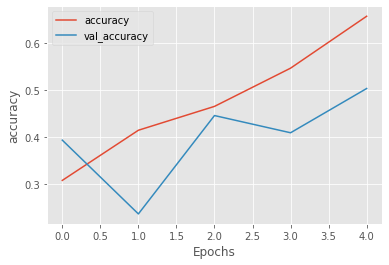

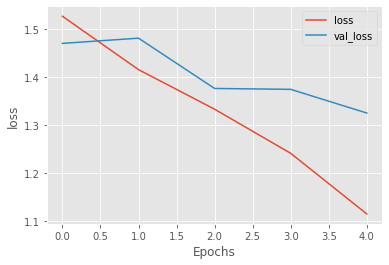

In [118]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [119]:
test_loss, test_accuracy = model_ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_accuracy))

12/12 [==============================] - 1s 49ms/step - loss: 1.3312 - accuracy: 0.4921
Test set
  Loss: 1.331
  Accuracy: 0.492


In [120]:
history.history['accuracy']

[0.30694547295570374,
 0.4137415885925293,
 0.4645257592201233,
 0.5459297895431519,
 0.6564600467681885]

In [121]:
train_loss = history.history['loss'][4]
valid_loss = history.history['val_loss'][4]
valid_accuracy = history.history['val_accuracy'][4]

In [122]:
model_statistics.append(
        {
            'Activation Function': 'tanh',
            'Optimizer': 'sgd',
            'Training Loss': train_loss,
            'Validation Loss': valid_loss,
            'Validation Accuracy': valid_accuracy,
            'Test Accuracy': test_accuracy,
        }
    )

In [123]:
prediction_ffnn = model_ffnn.predict(X_test)
prediction_ffnn = np.argmax(prediction_ffnn, axis = 1)

In [124]:
accuracy = accuracy_score(df_test['labels'], prediction_ffnn)
accuracy_models[model_parameters] = accuracy
print(f'Accuracy of Model = {accuracy}')
print(classification_report(df_test['labels'], prediction_ffnn))

Accuracy of Model = 0.49214659685863876
              precision    recall  f1-score   support

           0       0.39      0.63      0.48        93
           1       0.68      0.30      0.42        76
           2       0.48      0.70      0.57        82
           3       0.55      0.14      0.23        42
           4       0.65      0.48      0.55        89

    accuracy                           0.49       382
   macro avg       0.55      0.45      0.45       382
weighted avg       0.54      0.49      0.48       382



In [125]:
df_stats = pd.DataFrame(data = model_statistics)
df_stats.to_csv("Statistics.csv", index = None)

#ReLU Activation and Adam Optimizer

In [154]:
model_ffnn = Sequential()
model_ffnn.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_ffnn.add(Flatten())
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(512, activation='relu'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(128, activation='relu'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(5, activation='softmax'))

In [155]:
model_ffnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ffnn.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 512, 100)          3129000   
                                                                 
 flatten_11 (Flatten)        (None, 51200)             0         
                                                                 
 dropout_33 (Dropout)        (None, 51200)             0         
                                                                 
 dense_33 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_34 (Dropout)        (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               65664     
                                                                 
 dropout_35 (Dropout)        (None, 128)             

In [156]:
history = model_ffnn.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
168/168 [==============================] - 39s 227ms/step - loss: 1.1519 - accuracy: 0.5190 - val_loss: 0.3753 - val_accuracy: 0.8796
Epoch 2/5
168/168 [==============================] - 38s 225ms/step - loss: 0.0501 - accuracy: 0.9888 - val_loss: 0.2195 - val_accuracy: 0.9267
Epoch 3/5
168/168 [==============================] - 37s 222ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.2132 - val_accuracy: 0.9424
Epoch 4/5
168/168 [==============================] - 37s 223ms/step - loss: 3.0993e-04 - accuracy: 1.0000 - val_loss: 0.2076 - val_accuracy: 0.9424
Epoch 5/5
168/168 [==============================] - 37s 223ms/step - loss: 1.0082e-04 - accuracy: 1.0000 - val_loss: 0.2126 - val_accuracy: 0.9424


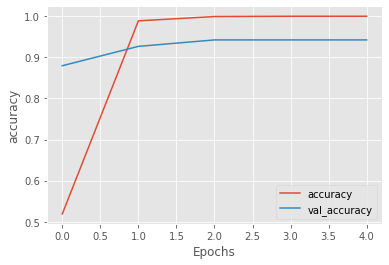

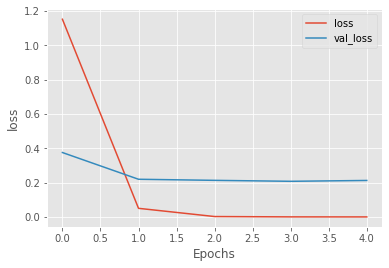

In [157]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [158]:
test_loss, test_accuracy = model_ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_accuracy))

12/12 [==============================] - 1s 47ms/step - loss: 0.1266 - accuracy: 0.9634
Test set
  Loss: 0.127
  Accuracy: 0.963


In [159]:
history.history['accuracy']

[0.519044041633606, 0.9887976050376892, 0.9992531538009644, 1.0, 1.0]

In [160]:
train_loss = history.history['loss'][4]
valid_loss = history.history['val_loss'][4]
valid_accuracy = history.history['val_accuracy'][4]

In [161]:
model_statistics.append(
        {
            'Activation Function': 'relu',
            'Optimizer': 'adam',
            'Training Loss': train_loss,
            'Validation Loss': valid_loss,
            'Validation Accuracy': valid_accuracy,
            'Test Accuracy': test_accuracy,
        }
    )

In [162]:
prediction_ffnn = model_ffnn.predict(X_test)
prediction_ffnn = np.argmax(prediction_ffnn, axis = 1)

In [163]:
accuracy = accuracy_score(df_test['labels'], prediction_ffnn)
accuracy_models[model_parameters] = accuracy
print(f'Accuracy of Model = {accuracy}')
print(classification_report(df_test['labels'], prediction_ffnn))

Accuracy of Model = 0.9633507853403142
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        93
           1       0.96      0.97      0.97        76
           2       0.99      0.94      0.96        82
           3       0.98      1.00      0.99        42
           4       0.99      0.94      0.97        89

    accuracy                           0.96       382
   macro avg       0.97      0.97      0.97       382
weighted avg       0.96      0.96      0.96       382



In [164]:
df_stats = pd.DataFrame(data = model_statistics)
df_stats.to_csv("Statistics.csv", index = None)

#ReLU Activation and SGD Optimizer

In [165]:
model_ffnn = Sequential()
model_ffnn.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_ffnn.add(Flatten())
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(512, activation='relu'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(128, activation='relu'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(5, activation='softmax'))

In [166]:
model_ffnn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(model_ffnn.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 512, 100)          3129000   
                                                                 
 flatten_12 (Flatten)        (None, 51200)             0         
                                                                 
 dropout_36 (Dropout)        (None, 51200)             0         
                                                                 
 dense_36 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_37 (Dropout)        (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               65664     
                                                                 
 dropout_38 (Dropout)        (None, 128)             

In [167]:
history = model_ffnn.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
168/168 [==============================] - 27s 155ms/step - loss: 1.5446 - accuracy: 0.2950 - val_loss: 1.4888 - val_accuracy: 0.3770
Epoch 2/5
168/168 [==============================] - 26s 154ms/step - loss: 1.4804 - accuracy: 0.3577 - val_loss: 1.4607 - val_accuracy: 0.3927
Epoch 3/5
168/168 [==============================] - 26s 154ms/step - loss: 1.4524 - accuracy: 0.3794 - val_loss: 1.4857 - val_accuracy: 0.3508
Epoch 4/5
168/168 [==============================] - 26s 153ms/step - loss: 1.4289 - accuracy: 0.3913 - val_loss: 1.4277 - val_accuracy: 0.3560
Epoch 5/5
168/168 [==============================] - 26s 154ms/step - loss: 1.3935 - accuracy: 0.4010 - val_loss: 1.4189 - val_accuracy: 0.3717


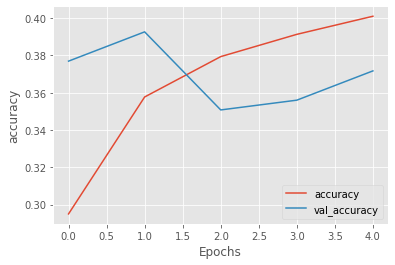

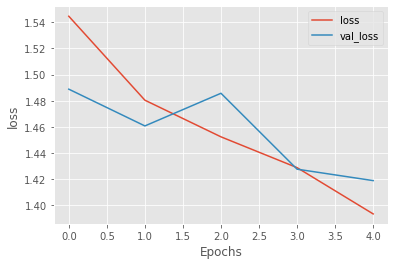

In [168]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [169]:
test_loss, test_accuracy = model_ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_accuracy))

12/12 [==============================] - 1s 46ms/step - loss: 1.4340 - accuracy: 0.3770
Test set
  Loss: 1.434
  Accuracy: 0.377


In [170]:
history.history['accuracy']

[0.2949962615966797,
 0.35772964358329773,
 0.37938761711120605,
 0.3913368284702301,
 0.401045560836792]

In [171]:
train_loss = history.history['loss'][4]
valid_loss = history.history['val_loss'][4]
valid_accuracy = history.history['val_accuracy'][4]

In [172]:
model_statistics.append(
        {
            'Activation Function': 'relu',
            'Optimizer': 'sgd',
            'Training Loss': train_loss,
            'Validation Loss': valid_loss,
            'Validation Accuracy': valid_accuracy,
            'Test Accuracy': test_accuracy,
        }
    )

In [173]:
prediction_ffnn = model_ffnn.predict(X_test)
prediction_ffnn = np.argmax(prediction_ffnn, axis = 1)

In [174]:
accuracy = accuracy_score(df_test['labels'], prediction_ffnn)
accuracy_models[model_parameters] = accuracy
print(f'Accuracy of Model = {accuracy}')
print(classification_report(df_test['labels'], prediction_ffnn))

Accuracy of Model = 0.3769633507853403
              precision    recall  f1-score   support

           0       0.36      0.31      0.34        93
           1       0.39      0.47      0.43        76
           2       0.34      0.70      0.46        82
           3       0.00      0.00      0.00        42
           4       0.52      0.25      0.34        89

    accuracy                           0.38       382
   macro avg       0.32      0.35      0.31       382
weighted avg       0.36      0.38      0.34       382



In [175]:
df_stats = pd.DataFrame(data = model_statistics)
df_stats.to_csv("Statistics.csv", index = None)

In [176]:
df_stats.to_csv("Q2_Statistics.csv", index = None)

#**Q3**

In [177]:
df

,Article,Class,labels,text,length
0,Cactus diet deal for Phytopharm\n\nA slimming ...,business,0,Cactus diet deal Phytopharm slimming aid made ...,143
1,Winter freeze keeps oil above $50\n\nOil price...,business,0,Winter freeze keeps oil 50 Oil prices carried ...,201
2,Mobiles rack up 20 years of use\n\nMobile phon...,tech,4,Mobiles rack 20 years use Mobile phones UK cel...,255
3,Giving financial gifts to children\n\nYour chi...,business,0,Giving financial gifts children child grandchi...,436
4,Bank payout to Pinochet victims\n\nA US bank h...,business,0,Bank payout Pinochet victims US bank said dona...,184
...,...,...,...,...,...
1907,Crucial decision on super-casinos\n\nA decisio...,politics,2,Crucial decision super casinos decision whethe...,108
1908,Cyber crime booms in 2004\n\nThe last 12 month...,tech,4,Cyber crime booms 2004 last 12 months seen dra...,471
1909,Howard rejects BNP's claim\n\nTory leader Mich...,politics,2,Howard rejects BNP claim Tory leader Michael H...,184
1910,Card fraudsters 'targeting web'\n\nNew safegua...,business,0,Card fraudsters targeting web New safeguards c...,248


In [180]:
X_cross = np.concatenate((X_train, X_valid), axis = 0)
Y_cross = np.concatenate((Y_train, Y_valid), axis = 0)

In [184]:
X1 = X_cross[0:math.ceil(0.33*len(X_cross))]
X2 = X_cross[math.ceil(0.33*len(X_cross)):math.ceil(0.67*len(X_cross))]
X3 = X_cross[math.ceil(0.67*len(X_cross)):]
Y1 = Y_cross[0:math.ceil(0.33*len(X_cross))]
Y2 = Y_cross[math.ceil(0.33*len(X_cross)):math.ceil(0.67*len(X_cross))]
Y3 = Y_cross[math.ceil(0.67*len(X_cross)):]

In [185]:
cross_validation = []

#First Cross Validation

In [186]:
X_train = np.concatenate((X1, X2), axis = 0)
Y_train = np.concatenate((Y1, Y2), axis = 0)
X_valid = X3
Y_valid = Y3

In [187]:
model_ffnn = Sequential()
model_ffnn.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_ffnn.add(Flatten())
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(512, activation='relu'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(128, activation='relu'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(5, activation='softmax'))

In [188]:
model_ffnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ffnn.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 512, 100)          3129000   
                                                                 
 flatten_13 (Flatten)        (None, 51200)             0         
                                                                 
 dropout_39 (Dropout)        (None, 51200)             0         
                                                                 
 dense_39 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_40 (Dropout)        (None, 512)               0         
                                                                 
 dense_40 (Dense)            (None, 128)               65664     
                                                                 
 dropout_41 (Dropout)        (None, 128)             

In [189]:
history = model_ffnn.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
129/129 [==============================] - 31s 234ms/step - loss: 1.4311 - accuracy: 0.4094 - val_loss: 0.8259 - val_accuracy: 0.7520
Epoch 2/5
129/129 [==============================] - 30s 232ms/step - loss: 0.1383 - accuracy: 0.9659 - val_loss: 0.2034 - val_accuracy: 0.9444
Epoch 3/5
129/129 [==============================] - 30s 230ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.1439 - val_accuracy: 0.9623
Epoch 4/5
129/129 [==============================] - 30s 231ms/step - loss: 5.9847e-04 - accuracy: 1.0000 - val_loss: 0.1398 - val_accuracy: 0.9623
Epoch 5/5
129/129 [==============================] - 30s 231ms/step - loss: 3.0840e-04 - accuracy: 1.0000 - val_loss: 0.1378 - val_accuracy: 0.9623


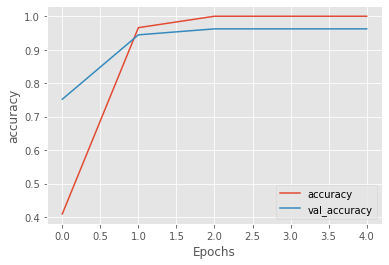

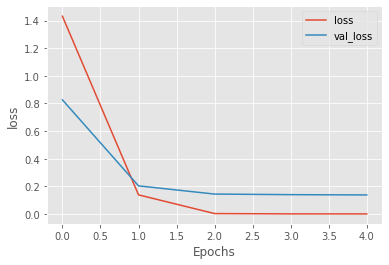

In [190]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [191]:
test_loss, test_accuracy = model_ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_accuracy))

12/12 [==============================] - 1s 45ms/step - loss: 0.1222 - accuracy: 0.9686
Test set
  Loss: 0.122
  Accuracy: 0.969


In [192]:
train_loss = history.history['loss'][4]
valid_loss = history.history['val_loss'][4]
valid_accuracy = history.history['val_accuracy'][4]

In [193]:
cross_validation.append(
        {
            'Training Loss': train_loss,
            'Validation Loss': valid_loss,
            'Validation Accuracy': valid_accuracy,
            'Test Accuracy': test_accuracy,
        }
    )

In [194]:
prediction_ffnn = model_ffnn.predict(X_test)
prediction_ffnn = np.argmax(prediction_ffnn, axis = 1)

In [195]:
accuracy = accuracy_score(df_test['labels'], prediction_ffnn)
accuracy_models[model_parameters] = accuracy
print(f'Accuracy of Model = {accuracy}')
print(classification_report(df_test['labels'], prediction_ffnn))

Accuracy of Model = 0.9685863874345549
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        93
           1       0.94      0.97      0.95        76
           2       0.95      0.98      0.96        82
           3       1.00      0.95      0.98        42
           4       0.98      0.97      0.97        89

    accuracy                           0.97       382
   macro avg       0.97      0.97      0.97       382
weighted avg       0.97      0.97      0.97       382



In [196]:
df_stats = pd.DataFrame(data = cross_validation)
df_stats.to_csv("Statistics.csv", index = None)

#Second Cross Validation

In [197]:
X_train = np.concatenate((X1, X3), axis = 0)
Y_train = np.concatenate((Y1, Y3), axis = 0)
X_valid = X2
Y_valid = Y2

In [198]:
model_ffnn = Sequential()
model_ffnn.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_ffnn.add(Flatten())
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(512, activation='relu'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(128, activation='relu'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(5, activation='softmax'))

In [199]:
model_ffnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ffnn.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 512, 100)          3129000   
                                                                 
 flatten_14 (Flatten)        (None, 51200)             0         
                                                                 
 dropout_42 (Dropout)        (None, 51200)             0         
                                                                 
 dense_42 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_43 (Dropout)        (None, 512)               0         
                                                                 
 dense_43 (Dense)            (None, 128)               65664     
                                                                 
 dropout_44 (Dropout)        (None, 128)             

In [200]:
history = model_ffnn.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
127/127 [==============================] - 30s 234ms/step - loss: 1.3774 - accuracy: 0.4192 - val_loss: 0.7643 - val_accuracy: 0.7044
Epoch 2/5
127/127 [==============================] - 29s 231ms/step - loss: 0.1304 - accuracy: 0.9643 - val_loss: 0.2346 - val_accuracy: 0.9271
Epoch 3/5
127/127 [==============================] - 29s 231ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1922 - val_accuracy: 0.9405
Epoch 4/5
127/127 [==============================] - 29s 232ms/step - loss: 3.6333e-04 - accuracy: 1.0000 - val_loss: 0.1873 - val_accuracy: 0.9424
Epoch 5/5
127/127 [==============================] - 29s 232ms/step - loss: 2.5326e-04 - accuracy: 1.0000 - val_loss: 0.1802 - val_accuracy: 0.9443


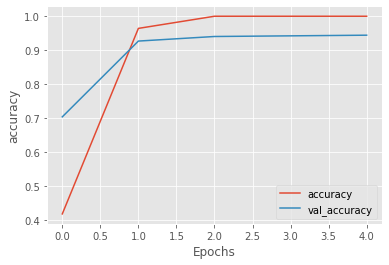

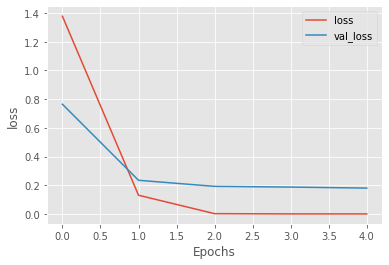

In [201]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [202]:
test_loss, test_accuracy = model_ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_accuracy))

12/12 [==============================] - 1s 44ms/step - loss: 0.1482 - accuracy: 0.9476
Test set
  Loss: 0.148
  Accuracy: 0.948


In [203]:
train_loss = history.history['loss'][4]
valid_loss = history.history['val_loss'][4]
valid_accuracy = history.history['val_accuracy'][4]

In [204]:
cross_validation.append(
        {
            'Training Loss': train_loss,
            'Validation Loss': valid_loss,
            'Validation Accuracy': valid_accuracy,
            'Test Accuracy': test_accuracy,
        }
    )

In [205]:
prediction_ffnn = model_ffnn.predict(X_test)
prediction_ffnn = np.argmax(prediction_ffnn, axis = 1)

In [206]:
accuracy = accuracy_score(df_test['labels'], prediction_ffnn)
accuracy_models[model_parameters] = accuracy
print(f'Accuracy of Model = {accuracy}')
print(classification_report(df_test['labels'], prediction_ffnn))

Accuracy of Model = 0.9476439790575916
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        93
           1       0.99      0.96      0.97        76
           2       0.94      0.94      0.94        82
           3       0.97      0.93      0.95        42
           4       0.97      0.93      0.95        89

    accuracy                           0.95       382
   macro avg       0.95      0.95      0.95       382
weighted avg       0.95      0.95      0.95       382



In [207]:
df_stats = pd.DataFrame(data = cross_validation)
df_stats.to_csv("Statistics.csv", index = None)

#Third Cross Validation

In [208]:
X_train = np.concatenate((X2, X3), axis = 0)
Y_train = np.concatenate((Y2, Y3), axis = 0)
X_valid = X1
Y_valid = Y1

In [209]:
model_ffnn = Sequential()
model_ffnn.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model_ffnn.add(Flatten())
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(512, activation='relu'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(128, activation='relu'))
model_ffnn.add(Dropout(0.2))
model_ffnn.add(Dense(5, activation='softmax'))

In [210]:
model_ffnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ffnn.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 512, 100)          3129000   
                                                                 
 flatten_15 (Flatten)        (None, 51200)             0         
                                                                 
 dropout_45 (Dropout)        (None, 51200)             0         
                                                                 
 dense_45 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_46 (Dropout)        (None, 512)               0         
                                                                 
 dense_46 (Dense)            (None, 128)               65664     
                                                                 
 dropout_47 (Dropout)        (None, 128)             

In [211]:
history = model_ffnn.fit(X_train, Y_train, epochs=num_epochs, batch_size = 8, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/5
129/129 [==============================] - 31s 232ms/step - loss: 1.3727 - accuracy: 0.4283 - val_loss: 0.5296 - val_accuracy: 0.8119
Epoch 2/5
129/129 [==============================] - 30s 230ms/step - loss: 0.1094 - accuracy: 0.9727 - val_loss: 0.1594 - val_accuracy: 0.9604
Epoch 3/5
129/129 [==============================] - 30s 229ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1207 - val_accuracy: 0.9683
Epoch 4/5
129/129 [==============================] - 30s 229ms/step - loss: 7.4800e-04 - accuracy: 1.0000 - val_loss: 0.1118 - val_accuracy: 0.9743
Epoch 5/5
129/129 [==============================] - 30s 231ms/step - loss: 3.5433e-04 - accuracy: 1.0000 - val_loss: 0.1086 - val_accuracy: 0.9723


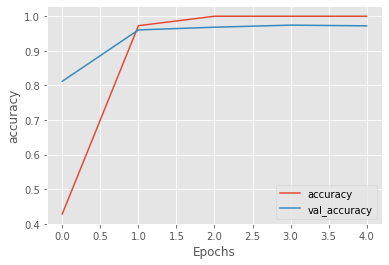

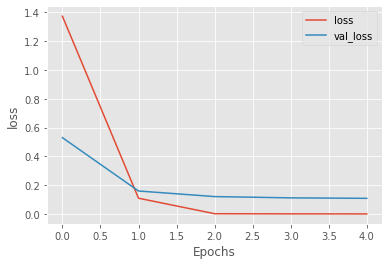

In [212]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [213]:
test_loss, test_accuracy = model_ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_accuracy))

12/12 [==============================] - 1s 45ms/step - loss: 0.1214 - accuracy: 0.9503
Test set
  Loss: 0.121
  Accuracy: 0.950


In [214]:
train_loss = history.history['loss'][4]
valid_loss = history.history['val_loss'][4]
valid_accuracy = history.history['val_accuracy'][4]

In [215]:
cross_validation.append(
        {
            'Training Loss': train_loss,
            'Validation Loss': valid_loss,
            'Validation Accuracy': valid_accuracy,
            'Test Accuracy': test_accuracy,
        }
    )

In [216]:
prediction_ffnn = model_ffnn.predict(X_test)
prediction_ffnn = np.argmax(prediction_ffnn, axis = 1)

In [217]:
accuracy = accuracy_score(df_test['labels'], prediction_ffnn)
accuracy_models[model_parameters] = accuracy
print(f'Accuracy of Model = {accuracy}')
print(classification_report(df_test['labels'], prediction_ffnn))

Accuracy of Model = 0.9502617801047121
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        93
           1       0.91      0.96      0.94        76
           2       0.97      0.93      0.95        82
           3       0.97      0.93      0.95        42
           4       0.97      0.96      0.96        89

    accuracy                           0.95       382
   macro avg       0.95      0.95      0.95       382
weighted avg       0.95      0.95      0.95       382



In [218]:
df_stats = pd.DataFrame(data = cross_validation)
df_stats.to_csv("Statistics.csv", index = None)

In [219]:
df_stats.to_csv("Q3_Statistics.csv")